# Predicting Answer Quality (Good-Bad) in Stack Overflow


## Group Members: 

1. Mayuri Kadam
2. Chinnu Pittapally

## Project Description: 

### Objective:

This project aims to predict the quality of answer as good or bad (i.e. if the answer gets any up-votes or not) on stack overflow. For simplicity we are dealing with questions and answers related to python only. Any answer on stack overflow that gets 1 or more up-votes we classify it as a GOOD (represented as 1) answer and answers having 0 or negative votes are classified as BAD (represented as 0) answers. Relevance of question to answers is established initially, to go forward with class prediction process. We will be using different models and bias criteria to predict the classes and finally consider one which predicts with the highest accuracy.
    

### 1. Data Collection:
   We have collected the dataset from Kaggle for stack overflow questions on python:
   https://www.kaggle.com/stackoverflow/pythonquestions
   
   The dataset contains questions up to 19 October 2016 (UTC).

   We have three csv files which hold data for questions, answers and tags for all the question related to python.
   
   Size of the data: ~1M answers
   
   This is organized as three tables: 
   1. Questions contain : title, body, creation date, score, and owner ID for each Python question.
   2. Answers contain  : body, creation date, score, and owner ID for each of the answers to these questions.The ParentId column links back to the Questions table.
   3. Tags contain : tags on each question. 

   
   
### 2. Data Pre-processing

1. Merging data : From the join of answers and questions table we mapped all the answers to their corresponding question using the   ParentId from answer table and Id from questions table
    
2. Establishing Target Class : From the merged table we extracted scores for every answer and categorized each of them as 'Good' if they had score greater than 0 and 'Bad' if score was 0 or less. This we call as our target variable/class
      
3. Dividing Train and Test sets : We have divided 60% of our dataset as train and the remaining as test set
    
4. Processing features : For the input matrix we considered the answers from the merged table and tokenized the answers' training set.
    The tokenize function flattens the text to lowercase. Also removes stopwords and words of length less than 2
    
5. X - matrix : We are using sklearn's CountVectorizer to create the vocabulary i.e. to generate features for our dataset. We used fit-transform to fit the input data to our vocabulary. 
       
    
### 2.1 Visualization

1. The target class (Score, Class) is visualized using histogram plot. From the histogram figure, we can observe most of our data lies between 0 to 100, while there many score values(higher scores) that are less frequent.

2. We plotted bar plot to show the range of values in the score and their frequency. From the bar plot, we can observe our data is skewed. More number of 'Good' answers are observed compared to 'Bad' answers.
  
3. We plotted the box plot for the target variable (score). We can observe that highest score goes up-to 8000 and most of the score values are in the 1st and 2nd quartile.
    
4. We have printed the top features (100 most frequent words) in our feature matrix. 

5. We also printed to most frequently used tags in the questions.

### 3 Model Evalution 

We are doing the evaluation of different classification models based on the precision score as the performance measure. We started our evaluation with two baselines: 1. Predicting the random class 2. Predicting the majority class.

After setting up the baseline for this classification task we have tried different parameter settings for the below models:

1. Logistic Regression (using CountVectorizer)
2. Logistic Regression (using TF-IDF vectorizer)
3. Naive Bayes ( using MultinomialNB)
4. Stochastic Gradient Descent(using SGD)
5. Suppport Vector Machine (using LinearSVC)
6. Neural Network (using MLPClassifier)

We have printed the performance measure and classification reports for all the settings we applied to different models. We have plotted graphs for the results of each setting for every model type. In the end we have plotted the graph for all the classifiers with differnt settings and picked the one that performed best across all.  



In [1]:
import re
import string
import numpy as np
import pandas as pd
import matplotlib.mlab as mlab
from collections import Counter
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.dummy import DummyClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
from itertools import product
from sklearn.metrics import confusion_matrix
from sklearn import linear_model
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import matthews_corrcoef
from sklearn import metrics
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.svm import LinearSVC


### Note: We have preprocessed data.  Please download from :
https://drive.google.com/open?id=0B6hJIF_NL2HsMk80Y0FOM3pWb3c


In [202]:
merged_df=pd.read_csv("Question_answer.csv",encoding="latin-1",nrows=100000)
merged_df.head()

,Unnamed: 0,Id_x,OwnerUserId_x,CreationDate_x,ParentId,Score_x,Body_x,Class,Id_y,OwnerUserId_y,CreationDate_y,Score_y,Title,Body_y
0,0,497,50.0,2008-08-02T16:56:53Z,469,4,<p>open up a terminal (Applications-&gt;Utilit...,1,469,147.0,2008-08-02T15:11:16Z,21,How can I find the full path to a font from it...,<p>I am using the Photoshop's javascript API t...
1,1,518,153.0,2008-08-02T17:42:28Z,469,2,<p>I haven't been able to find anything that d...,1,469,147.0,2008-08-02T15:11:16Z,21,How can I find the full path to a font from it...,<p>I am using the Photoshop's javascript API t...
2,2,3040,457.0,2008-08-06T03:01:23Z,469,12,<p>Unfortunately the only API that isn't depre...,1,469,147.0,2008-08-02T15:11:16Z,21,How can I find the full path to a font from it...,<p>I am using the Photoshop's javascript API t...
3,3,195170,745.0,2008-10-12T07:02:40Z,469,1,<p>There must be a method in Cocoa to get a li...,1,469,147.0,2008-08-02T15:11:16Z,21,How can I find the full path to a font from it...,<p>I am using the Photoshop's javascript API t...
4,4,536,161.0,2008-08-02T18:49:07Z,502,9,<p>You can use ImageMagick's convert utility f...,1,502,147.0,2008-08-02T17:01:58Z,27,Get a preview JPEG of a PDF on Windows?,<p>I have a cross-platform (Python) applicatio...


In [186]:
merged_df[['Score_x']].min()

Score_x   -24
dtype: int64

In [188]:
merged_df.loc[merged_df['Score_x'] <= -15]

,Unnamed: 0,Id_x,OwnerUserId_x,CreationDate_x,ParentId,Score_x,Body_x,Class,Id_y,OwnerUserId_y,CreationDate_y,Score_y,Title,Body_y
448,448,29347,1815.0,2008-08-27T01:50:48Z,28796,-18,"<p>Most editors support the ""whole word"" searc...",0,28796,2900.0,2008-08-26T18:26:51Z,52,What refactoring tools do you use for Python?,<p>I have a bunch of classes I want to rename....
4734,4734,188427,19435.0,2008-10-09T18:01:58Z,183042,-15,"<p>You could try writing a <a href=""http://www...",0,183042,7883.0,2008-10-08T14:26:20Z,26,How can I use UUIDs in SQLAlchemy?,<p>Is there a way to define a column (primary ...
12713,12713,474802,10661.0,2009-01-23T22:06:27Z,473620,-23,"<p>80% of the time, when folks say ""daemon"", t...",0,473620,2183.0,2009-01-23T16:48:06Z,185,How do you create a daemon in Python?,"<p><a href=""http://www.google.co.uk/search?q=p..."
18900,18900,688266,10661.0,2009-03-27T02:02:51Z,688245,-17,"<p>I use <a href=""http://www.activestate.com/k...",0,688245,76288.0,2009-03-27T01:57:33Z,17,Is there a better Python bundle for textmate t...,<p>At this time Textmate's official Python bun...
22117,22117,6407157,806071.0,2011-06-20T05:32:22Z,805066,-19,<p>This is a more abstract method:</p>\n\n\n\n...,0,805066,16513.0,2009-04-30T01:52:31Z,271,Call a parent class's method from child class ...,<p>When creating a simple object hierarchy in ...
38952,38952,1410442,101588.0,2009-09-11T11:55:51Z,1408940,-16,<p>If you're using JQuery this should do the t...,0,1408940,114672.0,2009-09-11T04:15:15Z,16,How do I hide the field label for a HiddenInpu...,<p>I've got a bit of Django form code that loo...
75442,75442,2654175,107366.0,2010-04-16T15:27:38Z,2654149,-17,<pre><code>import math\ndef number_of_bits(n):...,0,2654149,288832.0,2010-04-16T15:23:27Z,17,Count bits of a integer in Python,<pre><code>1 = 0b1 -&gt; 1\n5 = 0b101 -&gt; 3\...
77216,77216,2726384,84270.0,2010-04-28T02:03:19Z,2725852,-24,<blockquote>\n <p>I am unable to find example...,0,2725852,223912.0,2010-04-27T23:25:52Z,42,writing to existing workbook using xlwt,<p>I am unable to find examples where xlwt is ...


In [143]:
merged_df['Score_x'].idxmin()

77216

In [144]:
merged_df.ix[merged_df['Score_x'].idxmin()]

Unnamed: 0                                                    77216
Id_x                                                        2726384
OwnerUserId_x                                                 84270
CreationDate_x                                 2010-04-28T02:03:19Z
ParentId                                                    2725852
Score_x                                                         -24
Body_x            <blockquote>\n  <p>I am unable to find example...
Class                                                             0
Id_y                                                        2725852
OwnerUserId_y                                                223912
CreationDate_y                                 2010-04-27T23:25:52Z
Score_y                                                          42
Title                       writing to existing workbook using xlwt
Body_y            <p>I am unable to find examples where xlwt is ...
Name: 77216, dtype: object

In [189]:
df=merged_df.loc[merged_df['Score_x'] <= -15]
print(df)

       Unnamed: 0     Id_x  OwnerUserId_x        CreationDate_x  ParentId  \
448           448    29347         1815.0  2008-08-27T01:50:48Z     28796   
4734         4734   188427        19435.0  2008-10-09T18:01:58Z    183042   
12713       12713   474802        10661.0  2009-01-23T22:06:27Z    473620   
18900       18900   688266        10661.0  2009-03-27T02:02:51Z    688245   
22117       22117  6407157       806071.0  2011-06-20T05:32:22Z    805066   

       Score_x                                             Body_x  Class  \
448        -18  <p>Most editors support the "whole word" searc...      0   
4734       -15  <p>You could try writing a <a href="http://www...      0   
12713      -23  <p>80% of the time, when folks say "daemon", t...      0   
18900      -17  <p>I use <a href="http://www.activestate.com/k...      0   
22117      -19  <p>This is a more abstract method:</p>\n\n\n\n...      0   

         Id_y  OwnerUserId_y        CreationDate_y  Score_y  \
448     28796    

In [207]:
df2=merged_df.loc[merged_df['Score_x'] == -23]
df2

,Unnamed: 0,Id_x,OwnerUserId_x,CreationDate_x,ParentId,Score_x,Body_x,Class,Id_y,OwnerUserId_y,CreationDate_y,Score_y,Title,Body_y
12713,12713,474802,10661.0,2009-01-23T22:06:27Z,473620,-23,"<p>80% of the time, when folks say ""daemon"", t...",0,473620,2183.0,2009-01-23T16:48:06Z,185,How do you create a daemon in Python?,"<p><a href=""http://www.google.co.uk/search?q=p..."


In [211]:
pd.set_option('max_colwidth',2000)
df2

,Unnamed: 0,Id_x,OwnerUserId_x,CreationDate_x,ParentId,Score_x,Body_x,Class,Id_y,OwnerUserId_y,CreationDate_y,Score_y,Title,Body_y
12713,12713,474802,10661.0,2009-01-23T22:06:27Z,473620,-23,"<p>80% of the time, when folks say ""daemon"", they only want a server. Since the question is perfectly unclear on this point, it's hard to say what the possible domain of answers could be. Since a server is adequate, start there. If an actual ""daemon"" is actually needed (this is rare), read up on <code>nohup</code> as a way to daemonize a server.</p>\n\n<p>Until such time as an actual daemon is actually required, just write a simple server.</p>\n\n<p>Also look at the <a href=""http://www.python.org/doc/2.5.2/lib/module-wsgiref.html"" rel=""nofollow"">WSGI reference</a> implementation.</p>\n\n<p>Also look at the <a href=""http://www.python.org/doc/2.5.2/lib/module-SimpleHTTPServer.html"" rel=""nofollow"">Simple HTTP Server</a>.</p>\n\n<p>""Are there any additional things that need to be considered? "" Yes. About a million things. What protocol? How many requests? How long to service each request? How frequently will they arrive? Will you use a dedicated process? Threads? Subprocesses? Writing a daemon is a big job. </p>\n",0,473620,2183.0,2009-01-23T16:48:06Z,185,How do you create a daemon in Python?,"<p><a href=""http://www.google.co.uk/search?q=python+daemon"">Searching on Google</a> reveals x2 code snippets. The first result is to <a href=""http://code.activestate.com/recipes/278731/"">this code recipe</a> which has a lot of documentation and explanation, along with some useful discussion underneath. </p>\n\n<p>However, <a href=""http://www.jejik.com/articles/2007/02/a_simple_unix_linux_daemon_in_python/"">another code sample</a>, whilst not containing so much documentation, includes sample code for passing commands such as start, stop and restart. It also creates a PID file which can be handy for checking if the daemon is already running etc.</p>\n\n<p>These samples both explain how to create the daemon. Are there any additional things that need to be considered? Is one sample better than the other, and why?</p>\n"


In [190]:
#Pre-processing the target variable

target_df=merged_df[['Score_x','Class']]
target_df.columns=['Score','Class']
target_df.head()

t_df=df[['Score_x','Class']]
t_df.columns=['Score','Class']
t_df.head()

,Score,Class
448,-18,0
4734,-15,0
12713,-23,0
18900,-17,0
22117,-19,0


In [191]:
arr=["Score_y","Score_x","Class"]
merged_df=merged_df.drop("Score_y",1)
merged_df=merged_df.drop("Score_x",1)
merged_df=merged_df.drop("Class",1)
merged_df.head()

,Unnamed: 0,Id_x,OwnerUserId_x,CreationDate_x,ParentId,Body_x,Id_y,OwnerUserId_y,CreationDate_y,Title,Body_y
0,0,497,50.0,2008-08-02T16:56:53Z,469,<p>open up a terminal (Applications-&gt;Utilit...,469,147.0,2008-08-02T15:11:16Z,How can I find the full path to a font from it...,<p>I am using the Photoshop's javascript API t...
1,1,518,153.0,2008-08-02T17:42:28Z,469,<p>I haven't been able to find anything that d...,469,147.0,2008-08-02T15:11:16Z,How can I find the full path to a font from it...,<p>I am using the Photoshop's javascript API t...
2,2,3040,457.0,2008-08-06T03:01:23Z,469,<p>Unfortunately the only API that isn't depre...,469,147.0,2008-08-02T15:11:16Z,How can I find the full path to a font from it...,<p>I am using the Photoshop's javascript API t...
3,3,195170,745.0,2008-10-12T07:02:40Z,469,<p>There must be a method in Cocoa to get a li...,469,147.0,2008-08-02T15:11:16Z,How can I find the full path to a font from it...,<p>I am using the Photoshop's javascript API t...
4,4,536,161.0,2008-08-02T18:49:07Z,502,<p>You can use ImageMagick's convert utility f...,502,147.0,2008-08-02T17:01:58Z,Get a preview JPEG of a PDF on Windows?,<p>I have a cross-platform (Python) applicatio...


In [193]:
arr=["Score_y","Score_x","Class"]
df=df.drop("Score_y",1)
df=df.drop("Score_x",1)
df=df.drop("Class",1)


ValueError: labels ['Score_y'] not contained in axis

In [194]:
merged_df=merged_df[['Title','Body_y','Body_x','CreationDate_x']]
merged_df.columns=['Question_title','Question_body','Answer','Creation_date']

In [195]:
df=df[['Title','Body_y','Body_x','CreationDate_x']]
df.columns=['Question_title','Question_body','Answer','Creation_date']


In [6]:


X_train, X_test, y_train, y_test = train_test_split(merged_df, target_df, test_size=0.33, random_state=42)

target_train_df=y_train
target_test_df=y_test
input_train_df=X_train
input_test_df=X_test

#Size of train and test set

print("Train size is : ",len(input_train_df))
print("Test size is : ",len(input_test_df))

Train size is :  67000
Test size is :  33000


In [7]:
#Mean Score for the Target training set

print("Mean =",target_train_df['Score'].mean())
print("Variance=",target_train_df['Score'].var())

Mean = 9.28914925373
Variance= 4146.02136318


In [8]:
#function to tokenize and remove the stop words

stop = stopwords.words('english') 

def tokenize(text):
    tokens =[]
    tokens = re.sub('\W+', ' ', text.lower()).split() 
    tokens = [x for x in tokens if ((x not in stop) and len(x)>2)]
    return ' '.join(x for x in tokens)


In [197]:
#Merging questions and answers and tokenizing

cl_df=[tokenize(x) for x in (merged_df['Question_body']+ merged_df['Answer'])] 

In [171]:
X_train, X_test, y_train, y_test = train_test_split((merged_df['Question_body']+ merged_df['Answer']), target_df['Class'], test_size=0.33, random_state=42)
print(X_train.shape)


(67000,)


In [174]:
(df['Question_body']+ df['Answer'])

77214    <p>I am unable to find examples where xlwt is ...
77215    <p>I am unable to find examples where xlwt is ...
77216    <p>I am unable to find examples where xlwt is ...
77217    <p>I am unable to find examples where xlwt is ...
77218    <p>I am unable to find examples where xlwt is ...
dtype: object

In [176]:
X_train=X_train+(df['Question_body']+ df['Answer'])
print(X_train.shape)

(67002,)


In [163]:
X1=X_train+df

In [196]:
cl_df1=[tokenize(x) for x in (df['Question_body']+ df['Answer'])] 

In [198]:
#Creating the CountVectorizer
#vectorizer = TfidfVectorizer()
vec = TfidfVectorizer()
X_mtrx = vec.fit_transform(cl_df)
print("Shape of the input matrix is : ", X_mtrx.shape)

#Splitting the data into traina nd test

X_train, X_test, y_train, y_test = train_test_split(X_mtrx, target_df['Class'], test_size=0.33, random_state=42)



Shape of the input matrix is :  (100000, 229608)


In [199]:
#vec = CountVectorizer(input='content',binary=False)
X_mtrx1 = vec.transform(cl_df1)
print("Shape of the input matrix is : ", X_mtrx1.shape)


Shape of the input matrix is :  (8, 229608)


# Performance Measure :  Precision 

The precision is the ratio tp / (tp + fp) where tp is the number of true positives and fp the number of false positives. The precision is intuitively the ability of the classifier not to label as positive a sample that is negative.

#### Classfication Report
We are also printing the classification report for each setting

#### Matthews correlation coefficient (MCC)

The Matthews correlation coefficient is used in machine learning as a measure of the quality of binary (two-class) classifications. It takes into account true and false positives and negatives and is generally regarded as a balanced measure which can be used even if the classes are of very different sizes. The MCC is in essence a correlation coefficient value between -1 and +1. A coefficient of +1 represents a perfect prediction, 0 an average random prediction and -1 an inverse prediction. The statistic is also known as the phi coefficient.

Since our data is skewed, we decided to print the Matthews correlation coefficient (MCC).


In [11]:
#perf_scores is a dictionary to store the scores. 

perf_scores={}

# Baseline Settings 

### Baseline 1

In [12]:
## Baseline Classifier predicting the random class 

clf=DummyClassifier(strategy="uniform")
clf.fit(X_train,y_train)

DummyClassifier(constant=None, random_state=None, strategy='uniform')

In [13]:
print("Accuracy of trained model: %0.3f "%clf.score(X_train,y_train))

scores = cross_val_score(clf, X_train, y_train, cv=10, scoring ='precision')
print("10 fold Precsion_score of trained model: %0.3f "% (np.mean(scores)))

scores = cross_val_score(clf, X_train, y_train, cv=10, scoring='accuracy')
print("10 fold Accuracy_score of trained model: %0.3f "% (np.mean(scores)))


Accuracy of trained model: 0.500 
10 fold Precsion_score of trained model: 0.769 
10 fold Accuracy_score of trained model: 0.502 


In [14]:
pred_test =  clf.predict(X_test)
print("Accuracy of test model: %0.3f \n"%clf.score(X_test, y_test))

print("Classification Report \n")
print(classification_report(y_test, pred_test))

Accuracy of test model: 0.503 

Classification Report 

             precision    recall  f1-score   support

          0       0.23      0.50      0.31      7577
          1       0.77      0.50      0.60     25423

avg / total       0.65      0.50      0.54     33000



In [15]:
print(matthews_corrcoef(y_test, pred_test))
baseline1=precision_recall_fscore_support(y_test, pred_test, average = 'weighted')[0]

-0.00186831340794


### Baseline 2

In [16]:
#Predicting the accuracy if predicted the majority class  

clf=DummyClassifier(strategy="most_frequent")
clf.fit(X_train,y_train)

DummyClassifier(constant=None, random_state=None, strategy='most_frequent')

In [17]:
print("Accuracy of trained model: %0.3f "%clf.score(X_train,y_train))

scores = cross_val_score(clf,X_train ,y_train, cv=10,scoring='precision')
print("10 fold Precsion_score of trained model: %0.3f "% (np.mean(scores)))

scores = cross_val_score(clf,X_train ,y_train, cv=10,scoring='accuracy')
print("10 fold Accuracy_score of trained model: %0.3f "% (np.mean(scores)))

Accuracy of trained model: 0.772 
10 fold Precsion_score of trained model: 0.772 
10 fold Accuracy_score of trained model: 0.772 


In [18]:
pred_test=clf.predict(X_test)
print("Accuracy of test model: %0.3f "%clf.score(X_test,y_test))

print("Classification Report \n")
print(classification_report(y_test, pred_test))

Accuracy of test model: 0.770 
Classification Report 

             precision    recall  f1-score   support

          0       0.00      0.00      0.00      7577
          1       0.77      1.00      0.87     25423

avg / total       0.59      0.77      0.67     33000



/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [19]:
print(matthews_corrcoef(y_test, pred_test))
baseline2=precision_recall_fscore_support(y_test, pred_test, average = 'weighted')[0]

0.0


/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/metrics/classification.py:516: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(var_yt * var_yp)
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


# Model Evalution

## 1. Logistic Regression 

### 1.1 Default Setting

In [20]:
#Logistic Regression 
clf = LogisticRegression()
clf.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [21]:
print("Accuracy of trained model: %0.3f "%clf.score(X_train,y_train))

scores = cross_val_score(clf,X_train ,y_train, cv=10,scoring='precision')
print("10 fold Precsion_score of trained model: %0.3f "% (np.mean(scores)))

scores = cross_val_score(clf,X_train ,y_train, cv=10,scoring='accuracy')
print("10 fold Accuracy_score of trained model: %0.3f "% (np.mean(scores)))

Accuracy of trained model: 0.773 
10 fold Precsion_score of trained model: 0.773 
10 fold Accuracy_score of trained model: 0.771 


In [22]:
#Predicting for the Test set

pred_test = clf.predict(X_test)
print("Accuracy of test set: %0.3f "%clf.score(X_test,y_test))

print("Classification Report for predicted test set\n")
print(classification_report(y_test, pred_test))

Accuracy of test set: 0.770 
Classification Report for predicted test set

             precision    recall  f1-score   support

          0       0.45      0.01      0.01      7577
          1       0.77      1.00      0.87     25423

avg / total       0.70      0.77      0.67     33000



In [23]:
print(matthews_corrcoef(y_test, pred_test))

0.0301292014617


### 1.2 Logistic Regression with different parameter settings

In [24]:
lr_measure=[]
def classifier_combinations(cw,cval,rs):
    
    clf=LogisticRegression(class_weight=cw,C=cval,random_state=rs)
    clf.fit(X_train, y_train)
    pred_train=clf.predict(X_train)
    
    print("Classification Report for train set with class weight : %s C : %f random_state : %d "%(cw,cval,rs))
    print(classification_report(y_train, pred_train))
    
    pred_test=clf.predict(X_test)
    print("Classification Report for test set with class weight : %s C : %f random_state : %d"%(cw,cval,rs))
    print(classification_report(y_test, pred_test))
    
    lr_measure.append(precision_recall_fscore_support(y_test, pred_test, average='weighted'))
    print("___"*20)

##params
clas_weight=["balanced",None]
C_value=[0.1,1.0]
random_state=[20,42]

iterations=product(clas_weight,C_value,random_state)
for opt in iterations: 
    classifier_combinations(*opt)

## adding to performance dictionary
perf_scores["LR"]=lr_measure
    

Classification Report for train set with class weight : balanced C : 0.100000 random_state : 20 
             precision    recall  f1-score   support

          0       0.59      0.90      0.72     15268
          1       0.97      0.82      0.89     51732

avg / total       0.88      0.84      0.85     67000

Classification Report for test set with class weight : balanced C : 0.100000 random_state : 20
             precision    recall  f1-score   support

          0       0.30      0.45      0.36      7577
          1       0.81      0.69      0.75     25423

avg / total       0.69      0.64      0.66     33000

____________________________________________________________
Classification Report for train set with class weight : balanced C : 0.100000 random_state : 42 
             precision    recall  f1-score   support

          0       0.59      0.90      0.72     15268
          1       0.97      0.82      0.89     51732

avg / total       0.88      0.84      0.85     67000

Class

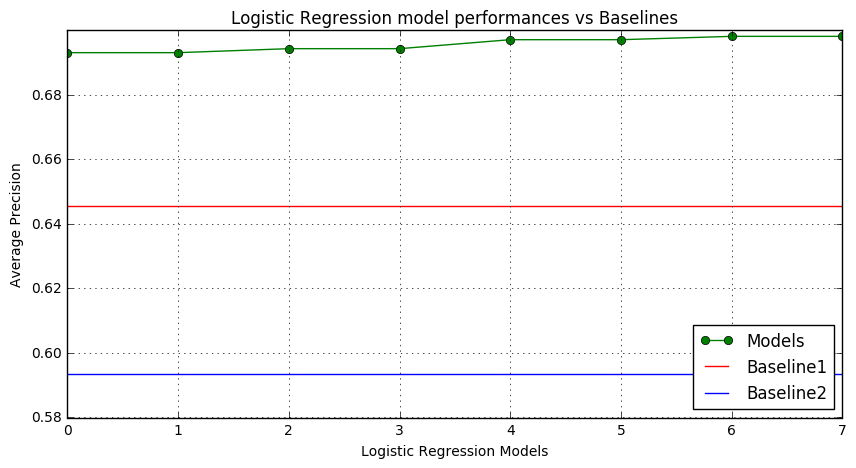

In [25]:
#Graph plotting different combination settings with precision values

x=[i for i in range(len(lr_measure))]
y=[i[0] for i in lr_measure]

yb1 = [baseline1]*len(x)
yb2 = [baseline2]*len(x)

plt.figure(figsize=(10,5)) 
plt.plot(x, y,'go-',label='Models') 
plt.plot(x, yb1, 'r-',label='Baseline1') 
plt.plot(x,yb2,'b-',label='Baseline2')
plt.xticks(x)
plt.grid() 
plt.title("Logistic Regression model performances vs Baselines") 
plt.xlabel('Logistic Regression Models') 
plt.ylabel('Average Precision') 
plt.legend(loc="lower right")
plt.show()

## 1.3 Best setting

In [26]:
#Best logistic regression Model

clf = LogisticRegression()
clf.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [27]:
scores = cross_val_score(clf,X_train ,y_train, cv=10,scoring='precision')
print("10 fold Precsion_score of trained model: %0.3f "% (np.mean(scores)))

scores = cross_val_score(clf,X_train ,y_train, cv=10,scoring='accuracy')
print("10 fold Accuracy_score of trained model: %0.3f "% (np.mean(scores)))

10 fold Precsion_score of trained model: 0.773 
10 fold Accuracy_score of trained model: 0.771 


In [28]:
#Predicting for the Test set

pred_test=clf.predict(X_test)
print("Accuracy of test set: %0.3f "%clf.score(X_test,y_test))

print("Classification Report for predicted test set\n")
print(classification_report(y_test, pred_test))
print(matthews_corrcoef(y_test, pred_test))

Accuracy of test set: 0.770 
Classification Report for predicted test set

             precision    recall  f1-score   support

          0       0.45      0.01      0.01      7577
          1       0.77      1.00      0.87     25423

avg / total       0.70      0.77      0.67     33000

0.0301292014617


# 2. Logistic regression using TF-IDF vectorizer 

### 2.1 Default Setting

In [155]:
#Logistic regression using TFIDF vectorizer
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(cl_df)

In [156]:
X_train, X_test, y_train, y_test = train_test_split(X, target_df['Class'], test_size=0.33, random_state=42)

In [31]:
print("Accuracy of trained model: %0.3f "%clf.score(X_train,y_train))

scores = cross_val_score(clf,X_train ,y_train, cv=10,scoring='precision')
print("10 fold Precsion_score of trained model: %0.3f "% (np.mean(scores)))

scores = cross_val_score(clf,X_train ,y_train, cv=10,scoring='accuracy')
print("10 fold Accuracy_score of trained model: %0.3f "% (np.mean(scores)))

Accuracy of trained model: 0.772 
10 fold Precsion_score of trained model: 0.774 
10 fold Accuracy_score of trained model: 0.771 


In [32]:
#Predicting for the Test set

pred_test = clf.predict(X_test)
print("Accuracy of test set: %0.3f "%clf.score(X_test,y_test))

print("Classification Report for predicted test set\n")
print(classification_report(y_test, pred_test))

Accuracy of test set: 0.770 
Classification Report for predicted test set

             precision    recall  f1-score   support

          0       0.00      0.00      0.00      7577
          1       0.77      1.00      0.87     25423

avg / total       0.59      0.77      0.67     33000



/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [33]:
print(matthews_corrcoef(y_test, pred_test))

0.0


/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/metrics/classification.py:516: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(var_yt * var_yp)


### 2.2 Logistic Regression Tf-idf with different parameter settings

In [34]:
lr_measure=[]
clas_weight=["balanced",None]
C_value=[0.1,1.0]
random_state=[20,42]

argnames=["Class weight: ", "C :", "random_state :"]
iterations=product(clas_weight,C_value,random_state)
for opt in iterations: 
    classifier_combinations(*opt)
perf_scores["LR_tfidf"]=lr_measure

Classification Report for train set with class weight : balanced C : 0.100000 random_state : 20 
             precision    recall  f1-score   support

          0       0.35      0.70      0.46     15268
          1       0.87      0.61      0.72     51732

avg / total       0.75      0.63      0.66     67000

Classification Report for test set with class weight : balanced C : 0.100000 random_state : 20
             precision    recall  f1-score   support

          0       0.30      0.59      0.40      7577
          1       0.83      0.58      0.68     25423

avg / total       0.71      0.59      0.62     33000

____________________________________________________________
Classification Report for train set with class weight : balanced C : 0.100000 random_state : 42 
             precision    recall  f1-score   support

          0       0.35      0.70      0.46     15268
          1       0.87      0.61      0.72     51732

avg / total       0.75      0.63      0.66     67000

Class

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Classification Report for train set with class weight : None C : 0.100000 random_state : 42 
             precision    recall  f1-score   support

          0       0.00      0.00      0.00     15268
          1       0.77      1.00      0.87     51732

avg / total       0.60      0.77      0.67     67000

Classification Report for test set with class weight : None C : 0.100000 random_state : 42
             precision    recall  f1-score   support

          0       0.00      0.00      0.00      7577
          1       0.77      1.00      0.87     25423

avg / total       0.59      0.77      0.67     33000

____________________________________________________________
Classification Report for train set with class weight : None C : 1.000000 random_state : 20 
             precision    recall  f1-score   support

          0       0.87      0.05      0.10     15268
          1       0.78      1.00      0.88     51732

avg / total       0.80      0.78      0.70     67000

Classification Re

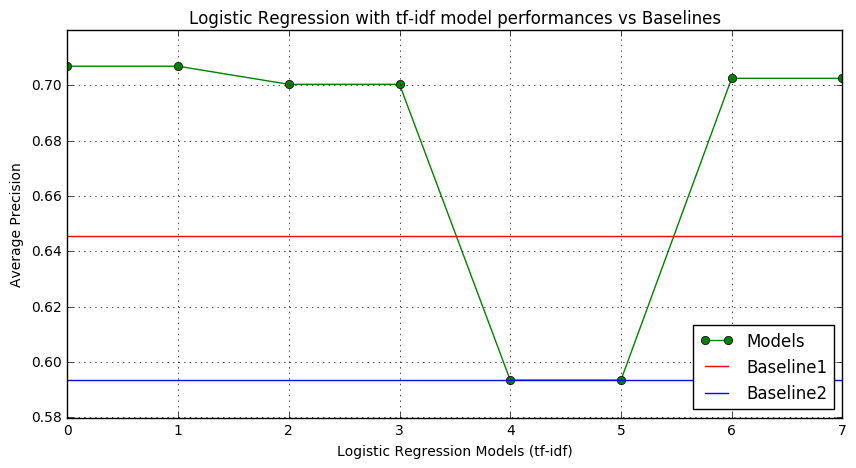

In [35]:
#Graph plotting different combination settings with precision values
x=[i for i in range(len(lr_measure))]
y=[i[0] for i in lr_measure]

yb1 = [baseline1]*len(x)
yb2 = [baseline2]*len(x)

plt.figure(figsize=(10,5)) 
plt.plot(x, y,'go-',label='Models') 
plt.plot(x, yb1, 'r-',label='Baseline1') 
plt.plot(x,yb2,'b-',label='Baseline2')
plt.xticks(x)
plt.grid() 
plt.title("Logistic Regression with tf-idf model performances vs Baselines") 
plt.xlabel('Logistic Regression Models (tf-idf)') 
plt.ylabel('Average Precision') 
plt.legend(loc="lower right")
plt.show()

### 2.3 Best Setting

In [36]:
#Best model for logistic regression with tf-idf
#Specfication : class weight : balanced C : 0.100000 random_state : 42

clf = LogisticRegression(class_weight="balanced", C=0.100000)
clf.fit(X_train, y_train)

LogisticRegression(C=0.1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [37]:
scores = cross_val_score(clf,X_train ,y_train, cv=10,scoring='precision')
print("10 fold Precsion_score of trained model: %0.3f "% (np.mean(scores)))
scores = cross_val_score(clf,X_train ,y_train, cv=10,scoring='accuracy')
print("10 fold Accuracy_score of trained model: %0.3f "% (np.mean(scores)))

10 fold Precsion_score of trained model: 0.831 
10 fold Accuracy_score of trained model: 0.583 


In [38]:
#Predicting for the Test set

pred_test=clf.predict(X_test)
print("Accuracy of test set: %0.3f "%clf.score(X_test,y_test))
print("Classification Report for predicted test set\n")
print(classification_report(y_test, pred_test))
print(matthews_corrcoef(y_test, pred_test))

Accuracy of test set: 0.586 
Classification Report for predicted test set

             precision    recall  f1-score   support

          0       0.30      0.59      0.40      7577
          1       0.83      0.58      0.68     25423

avg / total       0.71      0.59      0.62     33000

0.150714875718


## 3. Naive Bayes

### 3.1 Default Setting

In [39]:
#Naive Bayes Classifier

clf=MultinomialNB()
clf.fit(X_train, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [40]:
scores = cross_val_score(clf,X_train ,y_train, cv=10,scoring='precision')
print("10 fold Precsion_score of trained model: %0.3f "% (np.mean(scores)))
scores = cross_val_score(clf,X_train ,y_train, cv=10,scoring='accuracy')
print("10 fold Accuracy_score of trained model: %0.3f "% (np.mean(scores)))

10 fold Precsion_score of trained model: 0.772 
10 fold Accuracy_score of trained model: 0.772 


In [41]:
#Predicting for the Test set

pred_test=clf.predict(X_test)
print("Accuracy of test set: %0.3f "%clf.score(X_test,y_test))
print("Classification Report for predicted test set\n")
print(classification_report(y_test, pred_test))

Accuracy of test set: 0.770 
Classification Report for predicted test set

             precision    recall  f1-score   support

          0       0.50      0.00      0.00      7577
          1       0.77      1.00      0.87     25423

avg / total       0.71      0.77      0.67     33000



### 3.2 Naive Bayes with different parameter settings

In [42]:
nb_measure=[]
def classifier_combinations(al,fp):
    clf=MultinomialNB(alpha=al,fit_prior=fp)
    clf.fit(X_train, y_train)
    pred_train=clf.predict(X_train)
    print("\n Classification Report for train set with alpha : %0.3f fit_prior : %s "%(al,fp))
    print(classification_report(y_train, pred_train))
    print("Accuracy of trained model: %0.3f "%clf.score(X_train,y_train))
    print("Confusion Matrix \n" ,confusion_matrix(y_train,pred_train,[0,1]))
    pred_test=clf.predict(X_test)
    print("\n Classification Report for test set with alpha : %0.3f fit_prior : %s "%(al,fp))
    print(classification_report(y_test, pred_test))
    print("Accuracy of test set: %0.3f "%clf.score(X_test,y_test))
    print("Confusion Matrix \n" ,confusion_matrix(y_test,pred_test,[0,1]))
    nb_measure.append(precision_recall_fscore_support(y_test, pred_test, average='weighted'))
    print("___"*20)

## params
alpha=[.1,1,2]
fit_p=[True,False]
iterations=product(alpha,fit_p)

for opt in iterations: 
    classifier_combinations(*opt)
    
## add to dictionary
perf_scores["MNB"]=nb_measure


 Classification Report for train set with alpha : 0.100 fit_prior : True 
             precision    recall  f1-score   support

          0       0.89      0.27      0.41     15268
          1       0.82      0.99      0.90     51732

avg / total       0.84      0.83      0.79     67000

Accuracy of trained model: 0.826 
Confusion Matrix 
 [[ 4078 11190]
 [  489 51243]]

 Classification Report for test set with alpha : 0.100 fit_prior : True 
             precision    recall  f1-score   support

          0       0.33      0.09      0.14      7577
          1       0.78      0.95      0.85     25423

avg / total       0.68      0.75      0.69     33000

Accuracy of test set: 0.751 
Confusion Matrix 
 [[  653  6924]
 [ 1306 24117]]
____________________________________________________________

 Classification Report for train set with alpha : 0.100 fit_prior : False 
             precision    recall  f1-score   support

          0       0.74      0.60      0.66     15268
          1   

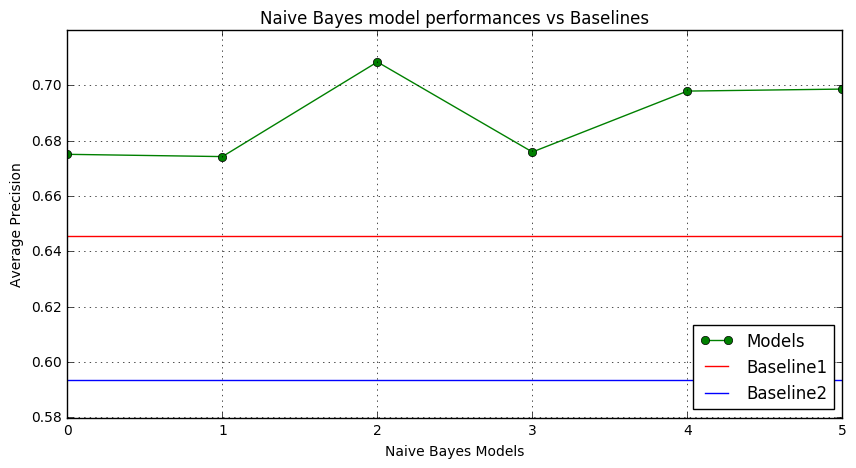

In [43]:
#Graph plotting different combination settings with precision values
x=[i for i in range(len(nb_measure))]
y=[i[0] for i in nb_measure]

yb1 = [baseline1]*len(x)
yb2 = [baseline2]*len(x)

plt.figure(figsize=(10,5)) 
plt.plot(x, y,'go-',label='Models') 
plt.plot(x, yb1, 'r-',label='Baseline1') 
plt.plot(x,yb2,'b-',label='Baseline2')
plt.xticks(x)
plt.grid() 
plt.title("Naive Bayes model performances vs Baselines") 
plt.xlabel('Naive Bayes Models') 
plt.ylabel('Average Precision') 
plt.legend(loc="lower right")
plt.show()

### 3.3 Best Setting

In [44]:
#Best Model settings

clf=MultinomialNB(alpha=1.000,fit_prior=True)
clf.fit(X_train, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [45]:
scores = cross_val_score(clf,X_train ,y_train, cv=10,scoring='precision')
print("10 fold Precsion_score of trained model: %0.3f "% (np.mean(scores)))
scores = cross_val_score(clf,X_train ,y_train, cv=10,scoring='accuracy')
print("10 fold Accuracy_score of trained model: %0.3f "% (np.mean(scores)))

10 fold Precsion_score of trained model: 0.772 
10 fold Accuracy_score of trained model: 0.772 


In [46]:
#Predicting for the Test set

pred_test=clf.predict(X_test)
print("Accuracy of test set: %0.3f "%clf.score(X_test,y_test))
print("Classification Report for predicted test set\n")
print(classification_report(y_test, pred_test))
print(matthews_corrcoef(y_test, pred_test))

Accuracy of test set: 0.770 
Classification Report for predicted test set

             precision    recall  f1-score   support

          0       0.50      0.00      0.00      7577
          1       0.77      1.00      0.87     25423

avg / total       0.71      0.77      0.67     33000

0.016605350012


## 4. Stochastic Gradient Descent Model 

### 4.1 Default Setting

In [47]:
clf_sgd = linear_model.SGDClassifier()
clf_sgd.fit(X_train, y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', n_iter=5, n_jobs=1,
       penalty='l2', power_t=0.5, random_state=None, shuffle=True,
       verbose=0, warm_start=False)

In [48]:
vec = CountVectorizer(input='content',binary=False)
X_mtrx = vec.fit_transform(cl_df)
print("Shape of the input matrix is : ", X_mtrx.shape)

Shape of the input matrix is :  (100000, 229608)


In [49]:
#Splitting the data into traina nd test

X_train, X_test, y_train, y_test = train_test_split(X_mtrx, target_df['Class'], test_size=0.33, random_state=42)

In [50]:
scores = cross_val_score(clf,X_train ,y_train, cv=10,scoring='precision')
print("10 fold Precsion_score of trained model: %0.3f "% (np.mean(scores)))
scores = cross_val_score(clf,X_train ,y_train, cv=10,scoring='accuracy')
print("10 fold Accuracy_score of trained model: %0.3f "% (np.mean(scores)))

10 fold Precsion_score of trained model: 0.787 
10 fold Accuracy_score of trained model: 0.713 


In [51]:
#Predicting for the Test set

pred_test=clf.predict(X_test)
print("Accuracy of test set: %0.3f "%clf.score(X_test,y_test))
print("Classification Report for predicted test set\n")
print(classification_report(y_test, pred_test))

Accuracy of test set: 0.770 
Classification Report for predicted test set

             precision    recall  f1-score   support

          0       0.44      0.00      0.00      7577
          1       0.77      1.00      0.87     25423

avg / total       0.69      0.77      0.67     33000



### 4.2 SGD with different parameter settings

In [52]:
sgd_measure=[]
def classifier_combinations(al,lo,cw):
    clf=linear_model.SGDClassifier(alpha=al, loss=lo,class_weight=cw)
    clf.fit(X_train, y_train)
    pred_train=clf.predict(X_train)
    print("\n Classification Report for train set with alpha : %0.3f loss : %s class_weight : %s "%(al,lo,cw))
    print(classification_report(y_train, pred_train))
    print("Accuracy of trained model: %0.3f "%clf.score(X_train,y_train))
    print("Confusion Matrix \n" ,confusion_matrix(y_train,pred_train,[0,1]))
    pred_test=clf.predict(X_test)
    print("\n Classification Report for train set with alpha : %0.3f loss : %s class_weight : %s "%(al,lo,cw))
    print(classification_report(y_test, pred_test))
    print("Accuracy of test set: %0.3f "%clf.score(X_test,y_test))
    print("Confusion Matrix \n" ,confusion_matrix(y_test,pred_test,[0,1]))
    sgd_measure.append(precision_recall_fscore_support(y_test, pred_test, average='weighted'))
    print("___"*20)

##params
alpha=[.0001,.001,.1]
loss=["hinge","modified_huber","perceptron"]
class_weight=[None, "balanced"]


iterations=product(alpha,loss,class_weight)
for opt in iterations: 
    classifier_combinations(*opt)
    
##add to dictionary    
perf_scores["SGD"]=sgd_measure


 Classification Report for train set with alpha : 0.000 loss : hinge class_weight : None 
             precision    recall  f1-score   support

          0       0.51      0.34      0.40     15268
          1       0.82      0.90      0.86     51732

avg / total       0.75      0.77      0.76     67000

Accuracy of trained model: 0.774 
Confusion Matrix 
 [[ 5149 10119]
 [ 5046 46686]]

 Classification Report for train set with alpha : 0.000 loss : hinge class_weight : None 
             precision    recall  f1-score   support

          0       0.31      0.20      0.24      7577
          1       0.78      0.87      0.82     25423

avg / total       0.67      0.71      0.69     33000

Accuracy of test set: 0.712 
Confusion Matrix 
 [[ 1505  6072]
 [ 3420 22003]]
____________________________________________________________

 Classification Report for train set with alpha : 0.000 loss : hinge class_weight : balanced 
             precision    recall  f1-score   support

          0    

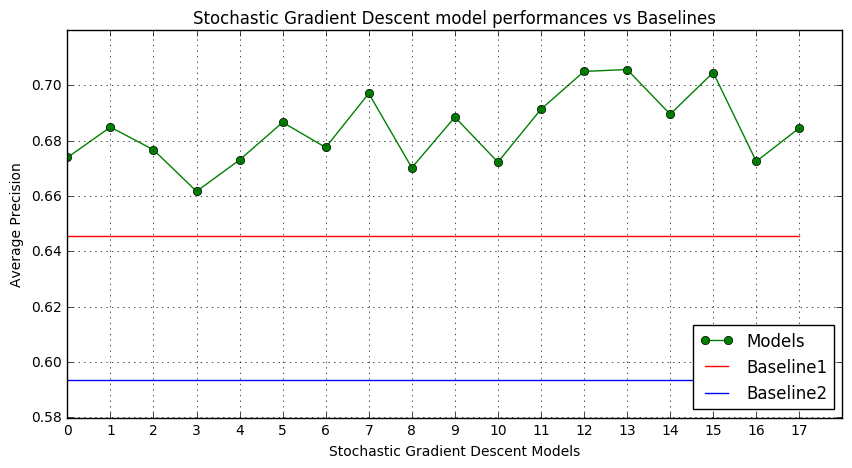

In [53]:
#Graph plotting different combination settings with precision values
x=[i for i in range(len(sgd_measure))]
y=[i[0] for i in sgd_measure]

yb1 = [baseline1]*len(x)
yb2 = [baseline2]*len(x)

plt.figure(figsize=(10,5)) 
plt.plot(x, y,'go-',label='Models') 
plt.plot(x, yb1, 'r-',label='Baseline1') 
plt.plot(x,yb2,'b-',label='Baseline2')
plt.xticks(x)
plt.grid() 
plt.title("Stochastic Gradient Descent model performances vs Baselines") 
plt.xlabel('Stochastic Gradient Descent Models') 
plt.ylabel('Average Precision') 
plt.legend(loc="lower right")
plt.show()

### 4.3 Best Setting

In [54]:
#Best Model settings

clf=linear_model.SGDClassifier(alpha=0.100, loss="modified_huber")
clf.fit(X_train, y_train)

SGDClassifier(alpha=0.1, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='modified_huber', n_iter=5, n_jobs=1,
       penalty='l2', power_t=0.5, random_state=None, shuffle=True,
       verbose=0, warm_start=False)

In [55]:
scores = cross_val_score(clf,X_train ,y_train, cv=10,scoring='precision')
print("10 fold Precsion_score of trained model: %0.3f "% (np.mean(scores)))
scores = cross_val_score(clf,X_train ,y_train, cv=10,scoring='accuracy')
print("10 fold Accuracy_score of trained model: %0.3f "% (np.mean(scores)))

10 fold Precsion_score of trained model: 0.774 
10 fold Accuracy_score of trained model: 0.771 


In [56]:
#Predicting for the Test set

pred_test=clf.predict(X_test)
print("Accuracy of test set: %0.3f "%clf.score(X_test,y_test))
print("Classification Report for predicted test set\n")
print(classification_report(y_test, pred_test))
print(matthews_corrcoef(y_test, pred_test))

Accuracy of test set: 0.769 
Classification Report for predicted test set

             precision    recall  f1-score   support

          0       0.36      0.01      0.02      7577
          1       0.77      0.99      0.87     25423

avg / total       0.68      0.77      0.67     33000

0.0239370357658


## 5.Support Vector Machines

### 5.1 Default Setting

In [57]:
clf = LinearSVC()
clf.fit(X_train, y_train)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [58]:
pred_train=clf.predict(X_train)
print(classification_report(y_train, pred_train))
print("Accuracy of trained model: %0.3f "%clf.score(X_train,y_train))

             precision    recall  f1-score   support

          0       0.98      0.94      0.96     15268
          1       0.98      0.99      0.99     51732

avg / total       0.98      0.98      0.98     67000

Accuracy of trained model: 0.983 


In [59]:
#Predicting for the Test set

pred_test=clf.predict(X_test)
print(classification_report(y_test, pred_test))
print("Accuracy of test set: %0.3f "%clf.score(X_test,y_test))
print(matthews_corrcoef(y_test, pred_test))

             precision    recall  f1-score   support

          0       0.30      0.31      0.31      7577
          1       0.79      0.78      0.79     25423

avg / total       0.68      0.67      0.68     33000

Accuracy of test set: 0.674 
0.0920335846656


### 5.2 Support Vector Machine with different parameter settings

In [60]:
svm_measure=[]
i=1
def classifier_combinations(c,cw,mi,lo):
    clf=LinearSVC(C=c,class_weight=cw,max_iter=mi,loss=lo)
    clf.fit(X_train, y_train)
    pred_train=clf.predict(X_train)
    global i
    print("Model Setting: %d \n"%i)
    i+=1
    print("C: %f class_weight: %s max_iter :%d loss :%s \n"%(c,cw,mi,lo))
    print("\n Classification Report for train set with")
    print(classification_report(y_train, pred_train))
    print("Accuracy of trained model: %0.3f "%clf.score(X_train,y_train))
    pred_test=clf.predict(X_test)
    print("\n Classification Report for test set ")
    print(classification_report(y_test, pred_test))
    print("Accuracy of test set: %0.3f \n"%clf.score(X_test,y_test))
    svm_measure.append(precision_recall_fscore_support(y_test, pred_test, average='weighted'))
    print("___"*20)

#params
C=[1.0,0.1,.01]
class_weight=["balanced"]
max_iter=[1000,10000]
loss=["hinge","squared_hinge"]


iterations=product(C,class_weight,max_iter,loss)
for opt in iterations: 
    classifier_combinations(*opt)
    
##add to dictionary
perf_scores["SVM"]=svm_measure

Model Setting: 1 

C: 1.000000 class_weight: balanced max_iter :1000 loss :hinge 


 Classification Report for train set with
             precision    recall  f1-score   support

          0       0.85      0.98      0.91     15268
          1       0.99      0.95      0.97     51732

avg / total       0.96      0.96      0.96     67000

Accuracy of trained model: 0.955 

 Classification Report for test set 
             precision    recall  f1-score   support

          0       0.30      0.37      0.33      7577
          1       0.80      0.74      0.77     25423

avg / total       0.68      0.65      0.66     33000

Accuracy of test set: 0.652 

____________________________________________________________
Model Setting: 2 

C: 1.000000 class_weight: balanced max_iter :1000 loss :squared_hinge 


 Classification Report for train set with
             precision    recall  f1-score   support

          0       0.93      0.98      0.95     15268
          1       0.99      0.98      0.

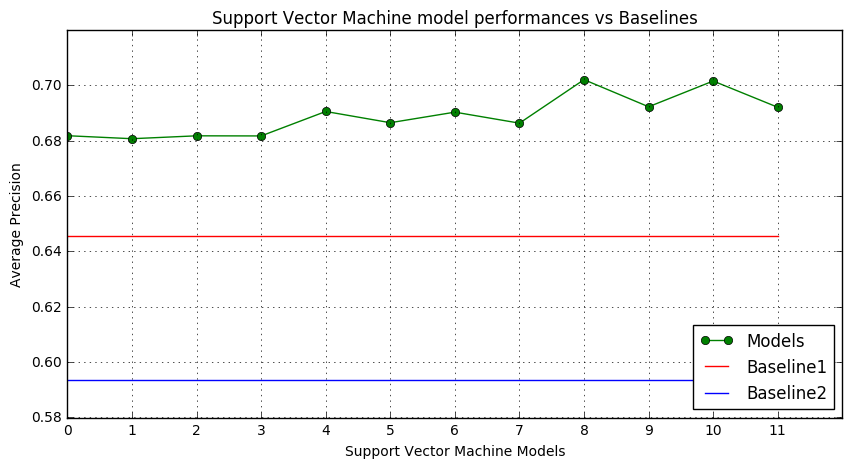

In [61]:
#Graph plotting different combination settings with precision values
x=[i for i in range(len(svm_measure))]
y=[i[0] for i in svm_measure]

yb1 = [baseline1]*len(x)
yb2 = [baseline2]*len(x)

plt.figure(figsize=(10,5)) 
plt.plot(x, y,'go-',label='Models') 
plt.plot(x, yb1, 'r-',label='Baseline1') 
plt.plot(x,yb2,'b-',label='Baseline2')
plt.xticks(x)
plt.grid() 
plt.title("Support Vector Machine model performances vs Baselines") 
plt.xlabel('Support Vector Machine Models') 
plt.ylabel('Average Precision') 
plt.legend(loc="lower right")
plt.show()

### 5.3 Best Setting

In [62]:
clf = LinearSVC(C=0.01, class_weight="balanced", max_iter=10000, loss="hinge")
clf.fit(X_train, y_train)

LinearSVC(C=0.01, class_weight='balanced', dual=True, fit_intercept=True,
     intercept_scaling=1, loss='hinge', max_iter=10000, multi_class='ovr',
     penalty='l2', random_state=None, tol=0.0001, verbose=0)

In [63]:
#This will take some considerable amount of time to run
scores = cross_val_score(clf,X_train ,y_train, cv=10,scoring='precision')
print("10 fold Precsion_score of trained model: %0.3f "% (np.mean(scores)))
scores = cross_val_score(clf,X_train ,y_train, cv=10,scoring='accuracy')
print("10 fold Accuracy_score of trained model: %0.3f "% (np.mean(scores)))

10 fold Precsion_score of trained model: 0.827 
10 fold Accuracy_score of trained model: 0.586 


In [64]:
#Predicting for the Test set

pred_test=clf.predict(X_test)
print(classification_report(y_test, pred_test))
print("Accuracy of test set: %0.3f "%clf.score(X_test,y_test))
print(matthews_corrcoef(y_test, pred_test))

             precision    recall  f1-score   support

          0       0.29      0.58      0.39      7577
          1       0.82      0.59      0.69     25423

avg / total       0.70      0.58      0.62     33000

Accuracy of test set: 0.585 
0.138335069469


## 6. Neural Network Model 


### 6.1 Default Setting

Warning 1: The neural network (MLPClassifier) takes time to run and sometikmes you might want to click the stop button to print the result. As per our observation it proccesses but is not able to output the result. Once you click the stop you can see the result below the cell.

Warning 2: For the differnt settings you might have to click the stop button 16 times (since there are 16 different parameter combinations we are trying to run)

In [65]:
clf = MLPClassifier()
clf.fit(X_train, y_train)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

In [66]:
pred_train=clf.predict(X_train)
print(classification_report(y_train, pred_train))
print("Accuracy of trained model: %0.3f "%clf.score(X_train,y_train))

             precision    recall  f1-score   support

          0       0.84      0.49      0.62     15268
          1       0.87      0.97      0.92     51732

avg / total       0.86      0.86      0.85     67000

Accuracy of trained model: 0.862 


In [67]:
#Predicting for the Test set

pred_test=clf.predict(X_test)
print(classification_report(y_test, pred_test))
print("Accuracy of test set: %0.3f "%clf.score(X_test,y_test))

             precision    recall  f1-score   support

          0       0.34      0.14      0.20      7577
          1       0.78      0.92      0.84     25423

avg / total       0.68      0.74      0.70     33000

Accuracy of test set: 0.739 


### 6.2 Neural Network with different parameter settings

In [79]:
nn_measure=[]
def classifier_combinations(hl,av,lr):
    clf=MLPClassifier(hidden_layer_sizes=hl,activation=av,learning_rate_init=lr)
    clf.fit(X_train, y_train)
    pred_train=clf.predict(X_train)
    print("\n Classification Report for train set with hidden_layer : ",hl)
    print("activation_fn : %s learning_rate : %f "%(av,lr))
    print(classification_report(y_train, pred_train))
    print("Accuracy of trained model: %0.3f "%clf.score(X_train,y_train))
    pred_test=clf.predict(X_test)
    print("\n Classification Report for test set with hidden_layer : ",hl)
    print("activation_fn : %s learning_rate : %f "%(av,lr))
    print(classification_report(y_test, pred_test))
    print("Accuracy of test set: %0.3f "%clf.score(X_test,y_test))
    nn_measure.append(precision_recall_fscore_support(y_test, pred_test, average='weighted'))
    print("___"*20)

##params
hidden_layer=[(100,),(2,)]
activation_fn=["identity","logistic","tanh","relu"]
learning_rate=[0.001,0.1]


iterations=product(hidden_layer,activation_fn,learning_rate)
for opt in iterations: 
    classifier_combinations(*opt)
    
##add to dictionary
perf_scores["NNMLP"]=nn_measure


 Classification Report for train set with hidden_layer :  (100,)
activation_fn : identity learning_rate : 0.001000 
             precision    recall  f1-score   support

          0       1.00      0.00      0.00     15268
          1       0.77      1.00      0.87     51732

avg / total       0.82      0.77      0.67     67000

Accuracy of trained model: 0.772 


KeyboardInterrupt: 

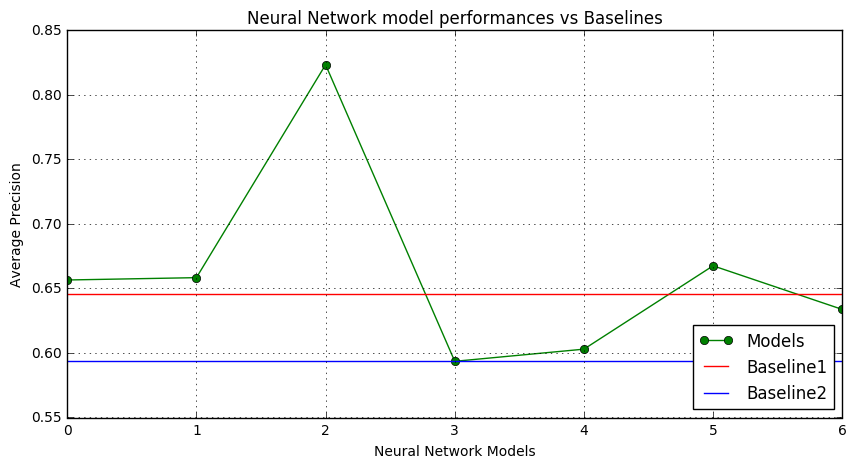

In [69]:
#Graph plotting different combination settings with precision values
x=[i for i in range(len(nn_measure))]
y=[i[0] for i in nn_measure]

yb1 = [baseline1]*len(x)
yb2 = [baseline2]*len(x)

plt.figure(figsize=(10,5)) 
plt.plot(x, y,'go-',label='Models') 
plt.plot(x, yb1, 'r-',label='Baseline1') 
plt.plot(x,yb2,'b-',label='Baseline2')
plt.xticks(x)
plt.grid() 
plt.title("Neural Network model performances vs Baselines") 
plt.xlabel('Neural Network Models') 
plt.ylabel('Average Precision') 
plt.legend(loc="lower right")
plt.show()

### 6.3 Best Setting

In [70]:
clf = MLPClassifier(hidden_layer_sizes=(2,),activation="identity",learning_rate_init=0.001)
clf.fit(X_train, y_train)

MLPClassifier(activation='identity', alpha=0.0001, batch_size='auto',
       beta_1=0.9, beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(2,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

In [71]:
#Predicting for the Test set

pred_test=clf.predict(X_test)
print(classification_report(y_test, pred_test))
print("Accuracy of test set: %0.3f "%clf.score(X_test,y_test))
print(matthews_corrcoef(y_test, pred_test))

             precision    recall  f1-score   support

          0       0.29      0.30      0.30      7577
          1       0.79      0.78      0.78     25423

avg / total       0.68      0.67      0.67     33000

Accuracy of test set: 0.670 
0.0823316614893


# Performance comparison of all the models

In [72]:
import collections
settings_per_model = collections.OrderedDict()

measure=[]
for k in perf_scores.keys():
    settings_per_model[k]=(len(perf_scores.get(k)))
    for each in perf_scores[k]:
        measure.append(each)
        
perf_meas =[]
  
for i in (measure):
    if i != None:
        if not(isinstance(i, float)) :
            val = i[0]
            perf_meas.append(val)
        else:
            perf_meas.append(i)
        

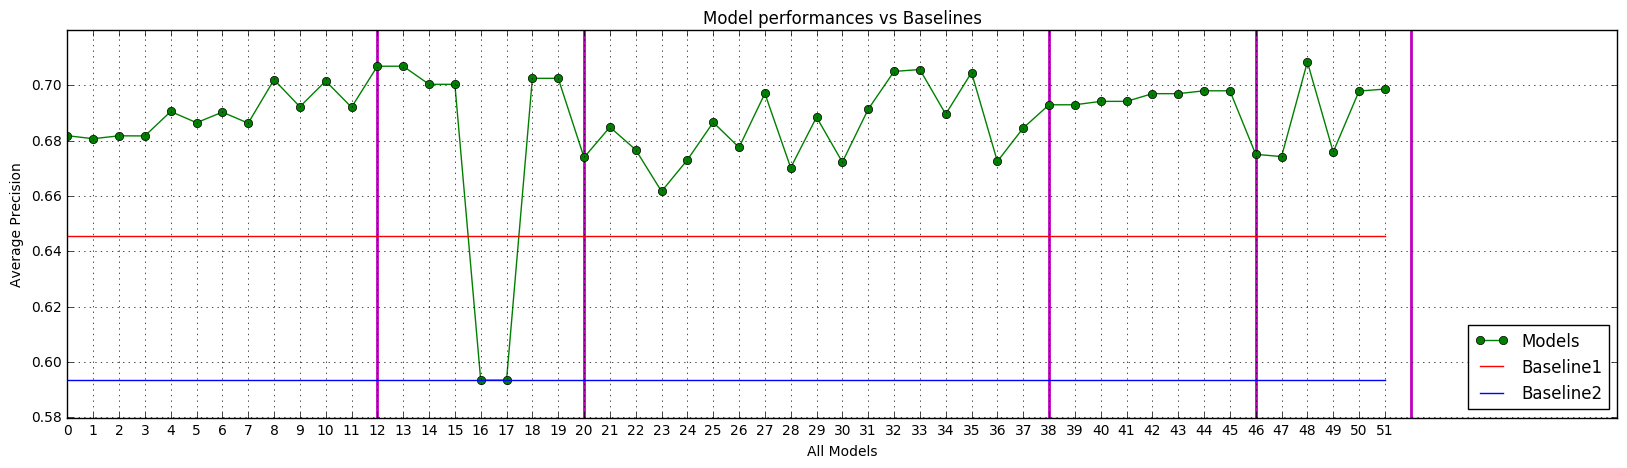

In [73]:
#Graph

x=[i for i in range(len(perf_meas))]
y=[i for i in perf_meas]

yb1 = [baseline1]*len(x)
yb2 = [baseline2]*len(x)
plt.figure(figsize=(20,5)) 

base_y = [1]
tot=0
for v in  settings_per_model.values():
    tot+=v
    plt.axvline(tot,color='m',linewidth=2)


plt.plot(x, y,'go-',label='Models') 
plt.plot(x, yb1, 'r-',label='Baseline1') 
plt.plot(x,yb2,'b-',label='Baseline2')
plt.xticks(x)
plt.grid() 
plt.title("Model performances vs Baselines") 
plt.xlabel('All Models') 
plt.ylabel('Average Precision') 
plt.legend(loc="lower right")
plt.show()


# Best of all classifiers

Note: Although we observed naive bayes showing better precision, we noticed there is no consistency to the precision value during different runs. Hence we choose the second best i.e. Logistic Regression with tf-idf vectorizer model as our best classifier. 

In [74]:
#Logistic regression using TFIDF vectorizer
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(cl_df)
X_train, X_test, y_train, y_test = train_test_split(X, target_df['Class'], test_size=0.33, random_state=42)

In [200]:
clf = LogisticRegression(class_weight="balanced", C=0.100000)
clf.fit(X_train, y_train)

LogisticRegression(C=0.1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [76]:
scores = cross_val_score(clf,X_train ,y_train, cv=10,scoring='precision')
print("10 fold Precsion_score of trained model: %0.3f "% (np.mean(scores)))
scores = cross_val_score(clf,X_train ,y_train, cv=10,scoring='accuracy')
print("10 fold Accuracy_score of trained model: %0.3f "% (np.mean(scores)))

10 fold Precsion_score of trained model: 0.831 
10 fold Accuracy_score of trained model: 0.583 


In [201]:
#Predicting for the Test set

pred_test=clf.predict(X_mtrx1)
print("Accuracy of test set: %0.3f "%clf.score(X_mtrx1,t_df['Class']))
print(pred_test)

Accuracy of test set: 0.375 
[0 1 1 1 1 1 0 0]


## Top Features

In [78]:
terms = np.array(vec.get_feature_names())
print('\nImportant Features and Coefficients')
coef = clf.coef_[0]
sorted_coefs = np.argsort(coef)
top_positive = sorted_coefs[::-1][:100]
top_negative = sorted_coefs[:100]

print('Positive Features:\n' + '\n'.join('%s (%g)' % (n, c) for n, c in zip(terms[top_positive], coef[top_positive])))
print('\nNegative Features:\n' + '\n'.join('%s (%g)' % (n, c) for n, c in zip(terms[top_negative], coef[top_negative])))


Important Features and Coefficients
Positive Features:
href (2.7344)
code (2.1003)
http (2.02101)
org (1.4948)
docs (1.46882)
python (0.873201)
numpy (0.83672)
library (0.790319)
timeit (0.757402)
course (0.723749)
datetime (0.718523)
note (0.692389)
strong (0.679418)
import (0.677524)
world (0.673994)
standard (0.626547)
matplotlib (0.62646)
twisted (0.620977)
objects (0.57886)
net (0.576838)
2008 (0.563522)
ctypes (0.561604)
pip (0.561423)
specific (0.554012)
blockquote (0.540237)
mod_wsgi (0.534431)
shutil (0.528746)
object (0.528501)
html (0.519284)
jpg (0.512725)
signal (0.508033)
mail (0.507019)
collections (0.506246)
itertools (0.504468)
operator (0.504191)
less (0.49824)
wiki (0.493328)
baz (0.483744)
blog (0.474217)
pre (0.474214)
per (0.473199)
look (0.471061)
perl (0.470735)
cls (0.467802)
much (0.464578)
documentation (0.459825)
features (0.458618)
uses (0.454914)
release (0.451655)
sys (0.448435)
support (0.444681)
complete (0.443626)
details (0.438414)
automatically (0.4

In [88]:
for key in perf_scores:
    print(key)
    for value in perf_scores.get(key):
        print(value)

SVM
(0.68180839015268535, 0.65200000000000002, 0.6649513142866299, None)
(0.68072366861139355, 0.66445454545454541, 0.67198124032745321, None)
(0.68176995131823304, 0.65230303030303027, 0.66512626151622589, None)
(0.6817249109090795, 0.6575151515151515, 0.66830507395206062, None)
(0.6905613348641787, 0.63242424242424244, 0.65435530179750723, None)
(0.68650517839522485, 0.65227272727272723, 0.66676433928823053, None)
(0.69032103908533415, 0.63221212121212123, 0.65414517478409107, None)
(0.68634317947865364, 0.65230303030303027, 0.66672906765342954, None)
(0.70205694752869074, 0.58545454545454545, 0.61807609348454584, None)
(0.69226324418267504, 0.63296969696969696, 0.65514863701533654, None)
(0.70156956491225575, 0.58490909090909093, 0.61757494863384554, None)
(0.69208294076873866, 0.63275757575757574, 0.65495280101437059, None)
LR_tfidf
(0.70691484505454438, 0.58618181818181814, 0.61889099716803742, None)
(0.70691484505454438, 0.58618181818181814, 0.61889099716803742, None)
(0.70037448